In [ ]:
# Import required libraries
import pandas as pd
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output, State
import plotly.graph_objects as go
import plotly.express as px
from dash import no_update


# Create a dash application
app = dash.Dash(__name__)

# REVIEW1: Clear the layout and do not display exception till callback gets executed
app.config.suppress_callback_exceptions = True

# Read the airline data into pandas dataframe
airline_data =  pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/airline_data.csv', 
                            encoding = "ISO-8859-1",
                            dtype={'Div1Airport': str, 'Div1TailNum': str, 
                                   'Div2Airport': str, 'Div2TailNum': str})


# List of years 
year_list = [i for i in range(2005, 2021, 1)]

"""Compute graph data for creating yearly airline performance report 

Function that takes airline data as input and create 5 dataframes based on the grouping condition to be used for plottling charts and grphs.

Argument:
     
    df: Filtered dataframe
    
Returns:
   Dataframes to create graph. 
"""
def compute_data_choice_1(df):
    # Cancellation Category Count
    bar_data = df.groupby(['Month','CancellationCode'])['Flights'].sum().reset_index()
    # Average flight time by reporting airline
    line_data = df.groupby(['Month','Reporting_Airline'])['AirTime'].mean().reset_index()
    # Diverted Airport Landings
    div_data = df[df['DivAirportLandings'] != 0.0]
    # Source state count
    map_data = df.groupby(['OriginState'])['Flights'].sum().reset_index()
    # Destination state count
    tree_data = df.groupby(['DestState', 'Reporting_Airline'])['Flights'].sum().reset_index()
    return bar_data, line_data, div_data, map_data, tree_data


"""Compute graph data for creating yearly airline delay report

This function takes in airline data and selected year as an input and performs computation for creating charts and plots.

Arguments:
    df: Input airline data.
    
Returns:
    Computed average dataframes for carrier delay, weather delay, NAS delay, security delay, and late aircraft delay.
"""
def compute_data_choice_2(df):
    # Compute delay averages
    avg_car = df.groupby(['Month','Reporting_Airline'])['CarrierDelay'].mean().reset_index()
    avg_weather = df.groupby(['Month','Reporting_Airline'])['WeatherDelay'].mean().reset_index()
    avg_NAS = df.groupby(['Month','Reporting_Airline'])['NASDelay'].mean().reset_index()
    avg_sec = df.groupby(['Month','Reporting_Airline'])['SecurityDelay'].mean().reset_index()
    avg_late = df.groupby(['Month','Reporting_Airline'])['LateAircraftDelay'].mean().reset_index()
    return avg_car, avg_weather, avg_NAS, avg_sec, avg_late


# Application layout
app.layout = html.Div(children=[ 
                                # TASK1: Add title to the dashboard
                                # Enter your code below. Make sure you have correct formatting.
                                 html.H1('US Domestic Airline Flights Performance', 
                                        style={'textAlign': 'center', 'color': '#503D36', 'font-size': 24}
                                       ),
                                # REVIEW2: Dropdown creation
                                # Create an outer division 
                                html.Div([
                                    # Add an division
                                    html.Div([
                                        # Create an division for adding dropdown helper text for report type
                                        html.Div(
                                            [
                                            html.H2('Report Type:', style={'margin-right': '2em'}),
                                            ]
                                        ),
                                        # TASK2: Add a dropdown
                                        # Enter your code below. Make sure you have correct formatting.
                                        dcc.Dropdown(id='input-type', 
                                        options=[
                                               {'label': 'Yearly Airline Performance Report', 'value': 'OPT1'},
                                               {'label': 'Yearly Airline Delay Report', 'value': 'OPT2'}
                                               ],
                                        placeholder='Select a report type',
                                        style={'width': '80%', 'padding': '3px', 'font-size': '20px', 'text-align-last':'center'})
                                    # Place them next to each other using the division style
                                    ], style={'display':'flex'}),
                                    
                                   # Add next division 
                                   html.Div([
                                       # Create an division for adding dropdown helper text for choosing year
                                        html.Div(
                                            [
                                            html.H2('Choose Year:', style={'margin-right': '2em'})
                                            ]
                                        ),
                                        dcc.Dropdown(id='input-year', 
                                                     # Update dropdown values using list comphrehension
                                                     options=[{'label': i, 'value': i} for i in year_list],
                                                     placeholder="Select a year",
                                                     style={'width':'80%', 'padding':'3px', 'font-size': '20px', 'text-align-last' : 'center'}),
                                            # Place them next to each other using the division style
                                            ], style={'display': 'flex'}),  
                                          ]),
                                
                                # Add Computed graphs
                                # REVIEW3: Observe how we add an empty division and providing an id that will be updated during callback
                                html.Div([ ], id='plot1'),
    
                                html.Div([
                                        html.Div([ ], id='plot2'),
                                        html.Div([ ], id='plot3')
                                ], style={'display': 'flex'}),
                                
                                # TASK3: Add a division with two empty divisions inside. See above disvision for example.
                                # Enter your code below. Make sure you have correct formatting.
                                html.Div([
                                        html.Div([ ], id='plot4'),
                                        html.Div([ ], id='plot5')
                                ], style={'display': 'flex'}),

                                ])

# Callback function definition
# TASK4: Add 5 ouput components
# Enter your code below. Make sure you have correct formatting.
@app.callback([Output(component_id='plot1', component_property='children'),
               Output(component_id='plot2', component_property='children'),
               Output(component_id='plot3', component_property='children'),
               Output(component_id='plot4', component_property='children'),
               Output(component_id='plot5', component_property='children')
               ],
               [Input(component_id='input-type', component_property='value'),
                Input(component_id='input-year', component_property='value')],
               # REVIEW4: Holding output state till user enters all the form information. In this case, it will be chart type and year
               [State("plot1", 'children'), State("plot2", "children"),
                State("plot3", "children"), State("plot4", "children"),
                State("plot5", "children")
               ])
# Add computation to callback function and return graph
def get_graph(chart, year, children1, children2, c3, c4, c5):
      
        # Select data
        df =  airline_data[airline_data['Year']==int(year)]
       
        if chart == 'OPT1':
            # Compute required information for creating graph from the data
            bar_data, line_data, div_data, map_data, tree_data = compute_data_choice_1(df)
            
            # Number of flights under different cancellation categories
            bar_fig = px.bar(bar_data, x='Month', y='Flights', color='CancellationCode', title='Monthly Flight Cancellation')
            
            # TASK5: Average flight time by reporting airline
            # Enter your code below. Make sure you have correct formatting.
            line_fig = px.line(line_data, x='Month', y='AirTime', color='Reporting_Airline', title='Average monthly flight time (minutes) by airline')
            
            # Percentage of diverted airport landings per reporting airline
            pie_fig = px.pie(div_data, values='Flights', names='Reporting_Airline', title='% of flights by reporting airline')
            
            # REVIEW5: Number of flights flying from each state using choropleth
            map_fig = px.choropleth(map_data,  # Input data
                    locations='OriginState', 
                    color='Flights',  
                    hover_data=['OriginState', 'Flights'], 
                    locationmode = 'USA-states', # Set to plot as US States
                    color_continuous_scale='GnBu',
                    range_color=[0, map_data['Flights'].max()]) 
            map_fig.update_layout(
                    title_text = 'Number of flights from origin state', 
                    geo_scope='usa') # Plot only the USA instead of globe
            
            # TASK6: Number of flights flying to each state from each reporting airline
            # Enter your code below. Make sure you have correct formatting.
            tree_fig = px.treemap(tree_data, path=['DestState', 'Reporting_Airline'], 
                      values='Flights',
                      color='Flights',
                      color_continuous_scale='RdBu',
                      title='Flight count by airline to destination state'
                )
            
            
            
            # REVIEW6: Return dcc.Graph component to the empty division
            return [dcc.Graph(figure=tree_fig), 
                    dcc.Graph(figure=pie_fig),
                    dcc.Graph(figure=map_fig),
                    dcc.Graph(figure=bar_fig),
                    dcc.Graph(figure=line_fig)
                   ]
        else:
            # REVIEW7: This covers chart type 2 and we have completed this exercise under Flight Delay Time Statistics Dashboard section
            # Compute required information for creating graph from the data
            avg_car, avg_weather, avg_NAS, avg_sec, avg_late = compute_data_choice_2(df)
            
            # Create graph
            carrier_fig = px.line(avg_car, x='Month', y='CarrierDelay', color='Reporting_Airline', title='Average carrrier delay time (minutes) by airline')
            weather_fig = px.line(avg_weather, x='Month', y='WeatherDelay', color='Reporting_Airline', title='Average weather delay time (minutes) by airline')
            nas_fig = px.line(avg_NAS, x='Month', y='NASDelay', color='Reporting_Airline', title='Average NAS delay time (minutes) by airline')
            sec_fig = px.line(avg_sec, x='Month', y='SecurityDelay', color='Reporting_Airline', title='Average security delay time (minutes) by airline')
            late_fig = px.line(avg_late, x='Month', y='LateAircraftDelay', color='Reporting_Airline', title='Average late aircraft delay time (minutes) by airline')
            
            return[dcc.Graph(figure=carrier_fig), 
                   dcc.Graph(figure=weather_fig), 
                   dcc.Graph(figure=nas_fig), 
                   dcc.Graph(figure=sec_fig), 
                   dcc.Graph(figure=late_fig)]


# Run the app
if __name__ == '__main__':
    app.run_server()

In [1]:
# ──────────────────────────────────────────
# Install / import everything once
# ──────────────────────────────────────────
!pip -q install yfinance beautifulsoup4 lxml requests plotly --upgrade

import pandas as pd
import yfinance as yf
import requests, re, time
from bs4 import BeautifulSoup
import plotly.graph_objects as go


In [3]:
# ──────────────────────────────────────────
# Download TSLA daily OHLCV (5 yrs)
# ──────────────────────────────────────────
tesla_data = yf.download("TSLA", period="5y", interval="1d")
tesla_data.reset_index(inplace=True)    
tesla_data.head()                      


/var/folders/q_/hzvv382958nd5xddc1lq2_xw0000gn/T/ipykernel_39875/574834789.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tesla_data = yf.download("TSLA", period="5y", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price        Date       Close        High        Low        Open     Volume
Ticker                   TSLA        TSLA       TSLA        TSLA       TSLA
0      2020-07-08   91.058670   94.484001  87.422668   93.666664  244669500
1      2020-07-09   92.952003   93.903999  90.085335   93.132668  175764000
2      2020-07-10  102.976669  103.261330  91.734001   93.066666  350064000
3      2020-07-13   99.804001  119.666000  98.073997  110.599998  584781000
4      2020-07-14  101.120003  106.000000  95.400002  103.733330  351271500

In [5]:
# ──────────────────────────────────────────
# Pull Tesla quarterly revenue from Macrotrends
# ──────────────────────────────────────────
def scrape_revenue(ticker: str) -> pd.DataFrame:
    url = f"https://www.macrotrends.net/stocks/charts/{ticker.lower()}/{ticker.lower()}/revenue"
    headers = {
        "User-Agent": "Mozilla/5.0",  # mimic a browser
        "Accept-Language": "en-US,en;q=0.9"
    }
    html = requests.get(url, headers=headers, timeout=30).text
    soup = BeautifulSoup(html, "lxml")

    # Find the correct table based on class and look for the second one (revenue table)
    tables = soup.find_all("table", {"class": "historical_data_table table"})
    if not tables or len(tables) < 2:
        raise ValueError("Revenue table not found — structure might have changed.")

    table = tables[1]  # Revenue table is usually the second one
    rows = table.find_all("tr")

    data = []
    for tr in rows:
        cols = [td.get_text(strip=True) for td in tr.find_all("td")]
        if len(cols) == 2 and cols[1] not in ["", "-"]:
            try:
                revenue = float(re.sub(r"[$,]", "", cols[1]))
                data.append({"Date": cols[0], "Revenue ($ M)": revenue})
            except ValueError:
                continue

    return pd.DataFrame(data)

tesla_revenue = scrape_revenue("TSLA")
tesla_revenue.tail() 


Date  Revenue ($ M)
58  2010-09-30           31.0
59  2010-06-30           28.0
60  2010-03-31           21.0
61  2009-09-30           46.0
62  2009-06-30           27.0

In [7]:
# ──────────────────────────────────────────
# Download GME daily OHLCV (5 yrs)
# ──────────────────────────────────────────
gme_data = yf.download("GME", period="5y", interval="1d")
gme_data.reset_index(inplace=True)      
gme_data.head()                         


/var/folders/q_/hzvv382958nd5xddc1lq2_xw0000gn/T/ipykernel_39875/390225389.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gme_data = yf.download("GME", period="5y", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price        Date   Close    High     Low    Open    Volume
Ticker                GME     GME     GME     GME       GME
0      2020-07-08  1.0650  1.0725  1.0075  1.0250   8211200
1      2020-07-09  1.0525  1.0800  1.0325  1.0675   7970400
2      2020-07-10  1.0850  1.0950  1.0450  1.0500   5643200
3      2020-07-13  1.0650  1.1375  1.0650  1.0875  16864800
4      2020-07-14  1.0200  1.0775  1.0175  1.0550   9046400

In [9]:
# ──────────────────────────────────────────
# Pull GME quarterly revenue
# ──────────────────────────────────────────
gme_revenue = scrape_revenue("GME")
gme_revenue.tail()                      


Date  Revenue ($ M)
61  2010-01-31         3524.0
62  2009-10-31         1835.0
63  2009-07-31         1739.0
64  2009-04-30         1981.0
65  2009-01-31         3492.0

In [11]:
# ──────────────────────────────────────────
# Generic line-plot builder (price vs date)
# ──────────────────────────────────────────
def make_graph(df, title, y_col="Close"):
    fig = go.Figure(
        data = go.Scatter(x=df["Date"], y=df[y_col], mode="lines", name=y_col)
    )
    fig.update_layout(title=title, xaxis_title="Date", yaxis_title=y_col)
    fig.show()


In [12]:
import plotly.io as pio
pio.renderers.default = "notebook"    

In [13]:
# ──────────────────────────────────────────
# Tesla price chart
# ──────────────────────────────────────────
make_graph(tesla_data, "Tesla (TSLA) Daily Close Price • Past 5 Years")


In [15]:
# ──────────────────────────────────────────
# GameStop price chart
# ──────────────────────────────────────────
make_graph(gme_data, "GameStop (GME) Daily Close Price • Past 5 Years")


In [17]:
# ──────────────────────────────────────────
# Tesla price vs revenue
# ──────────────────────────────────────────
fig_tesla = go.Figure()

# line – stock price
fig_tesla.add_trace(go.Scatter(
    x=tesla_data["Date"], y=tesla_data["Close"],
    name="Close Price ($)", line=dict(color="royalblue")
))

# bar – revenue (secondary y-axis)
fig_tesla.add_trace(go.Bar(
    x=pd.to_datetime(tesla_revenue["Date"]),
    y=tesla_revenue["Revenue ($ M)"], name="Quarterly Revenue ($ M)",
    marker_color="orange", opacity=0.6, yaxis="y2"
))

fig_tesla.update_layout(
    title="Tesla • Stock Price vs Quarterly Revenue",
    xaxis_title="Date",
    yaxis=dict(title="Close Price ($)"),
    yaxis2=dict(title="Revenue ($ M)", overlaying="y", side="right")
)
fig_tesla.show()

# ──────────────────────────────────────────
# GameStop price vs revenue
# ──────────────────────────────────────────
fig_gme = go.Figure()

fig_gme.add_trace(go.Scatter(
    x=gme_data["Date"], y=gme_data["Close"],
    name="Close Price ($)", line=dict(color="seagreen")
))

fig_gme.add_trace(go.Bar(
    x=pd.to_datetime(gme_revenue["Date"]),
    y=gme_revenue["Revenue ($ M)"],
    name="Quarterly Revenue ($ M)", marker_color="goldenrod",
    opacity=0.6, yaxis="y2"
))

fig_gme.update_layout(
    title="GameStop • Stock Price vs Quarterly Revenue",
    xaxis_title="Date",
    yaxis=dict(title="Close Price ($)"),
    yaxis2=dict(title="Revenue ($ M)", overlaying="y", side="right")
)
fig_gme.show()


In [ ]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# %pip install -qy pandas==1.3.4 numpy==1.21.4 matplotlib==3.5.0 seaborn folium
# Note: If your environment doesn't support "%pip install", use "!mamba install"

In [ ]:
%pip install seaborn
%pip install folium

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [ ]:
import requests
import io
import pandas as pd

# URL of the CSV file
URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/historical_automobile_sales.csv"

# Fetch the data from the URL
response = requests.get(URL)

# Raise an error if the request failed
response.raise_for_status()

# Convert the response content into a readable format for pandas
csv_content = io.StringIO(response.text)

# Read the CSV data into a pandas dataframe
df = pd.read_csv(csv_content)

# Print confirmation
print('Data downloaded and read into a dataframe!')

# Optional: Show the first few rows of the dataframe
print(df.head())


In [ ]:
df.describe()

In [ ]:
df.columns

In [ ]:
from pyodide.http import pyfetch

async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, "wb") as f:
            f.write(await response.bytes())

path = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/us-states.json'
await download(path, "us-states.json")

filename = "us-states.json"

In [ ]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# %pip install -qy pandas==1.3.4 numpy==1.21.4 matplotlib==3.5.0 seaborn folium
# Note: If your environment doesn't support "%pip install", use "!mamba install"

In [1]:
%pip install seaborn
%pip install folium

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [3]:
from js import fetch
import io

URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/historical_automobile_sales.csv"
resp = await fetch(URL)
text = io.BytesIO((await resp.arrayBuffer()).to_py())
import pandas as pd
df = pd.read_csv(text)
print('Data downloaded and read into a dataframe!')

Data downloaded and read into a dataframe!


In [4]:
df.describe()

Year   Recession  Consumer_Confidence  Seasonality_Weight  \
count   528.000000  528.000000           528.000000          528.000000   
mean   2001.500000    0.214015           101.140170            0.575795   
std      12.710467    0.410526            10.601154            0.454477   
min    1980.000000    0.000000            73.900000            0.000000   
25%    1990.750000    0.000000            94.035000            0.250000   
50%    2001.500000    0.000000           100.740000            0.500000   
75%    2012.250000    0.000000           108.240000            0.750000   
max    2023.000000    1.000000           131.670000            1.500000   

              Price  Advertising_Expenditure  Competition         GDP  \
count    528.000000               528.000000   528.000000  528.000000   
mean   24964.991956              3067.456439     6.064394   40.073903   
std     4888.073433              1139.564637     1.968350   16.249714   
min     8793.663000              1009.000000     3.000000   12.508000   
25%    21453.300500              2083.500000     4.000000   27.237500   
50%    25038.691500              3072.000000     6.000000   39.214500   
75%    28131.684750              4067.250000     8.000000   53.506500   
max    44263.657000              4983.000000     9.000000   70.374000   

       Growth_Rate  unemployment_rate  Automobile_Sales  
count   528.000000         528.000000        528.000000  
mean     -0.242001           2.453977       2352.718068  
std       0.861268           1.119019       1645.321284  
min      -4.227601           1.000000        102.000000  
25%      -0.574049           1.600000        793.950000  
50%      -0.013162           2.300000       2182.600000  
75%       0.388932           2.900000       3614.800000  
max       0.815074           6.000000      21147.000000

In [5]:
df.columns

Index(['Date', 'Year', 'Month', 'Recession', 'Consumer_Confidence',
       'Seasonality_Weight', 'Price', 'Advertising_Expenditure', 'Competition',
       'GDP', 'Growth_Rate', 'unemployment_rate', 'Automobile_Sales',
       'Vehicle_Type', 'City'],
      dtype='object')

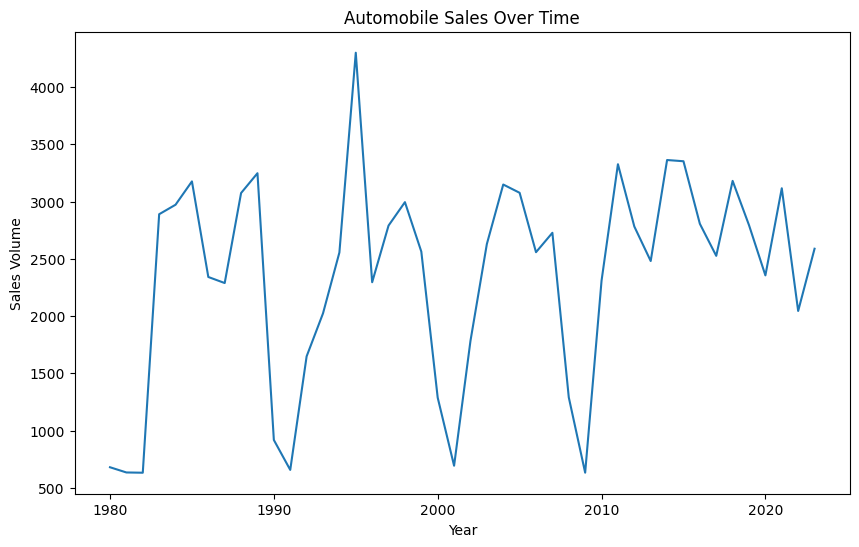

In [6]:
plt.figure(figsize = (10,6))
df_line = df.groupby('Year')['Automobile_Sales'].mean()
df_line.plot(kind='line',x=df_line.index,y=df_line.values)
plt.xlabel('Year')
plt.ylabel('Sales Volume')
plt.title('Automobile Sales Over Time')
plt.show()

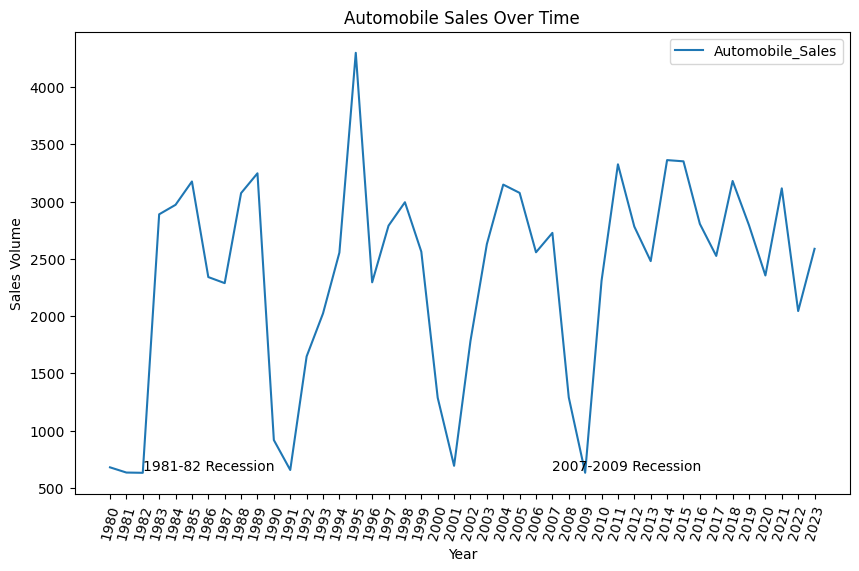

In [7]:
plt.figure(figsize =(10,6))
df_line = df.groupby('Year')['Automobile_Sales'].mean()
df_line.plot(kind='line',x=df_line.index,y=df_line.values)
plt.xticks(list(range(1980,2024)), rotation = 75)
plt.xlabel('Year')
plt.ylabel('Sales Volume')
plt.title('Automobile Sales Over Time')
plt.text(1982, 650, '1981-82 Recession')
plt.text(2007,650, '2007-2009 Recession')
plt.legend()
plt.show()

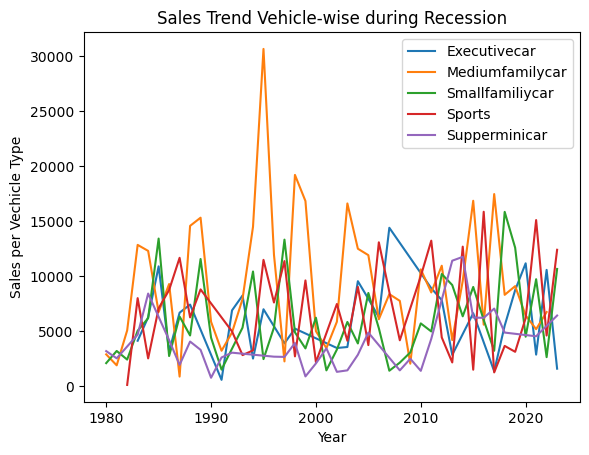

In [8]:
df_Mline = df.groupby(['Year','Vehicle_Type'], as_index=False)['Automobile_Sales'].sum()
df_Mline.set_index('Year', inplace=True)
df_Mline = df_Mline.groupby(['Vehicle_Type'])['Automobile_Sales']
df_Mline.plot(kind='line')
plt.xlabel('Year')
plt.ylabel('Sales per Vechicle Type')
plt.title('Sales Trend Vehicle-wise during Recession')
plt.legend()
plt.show()

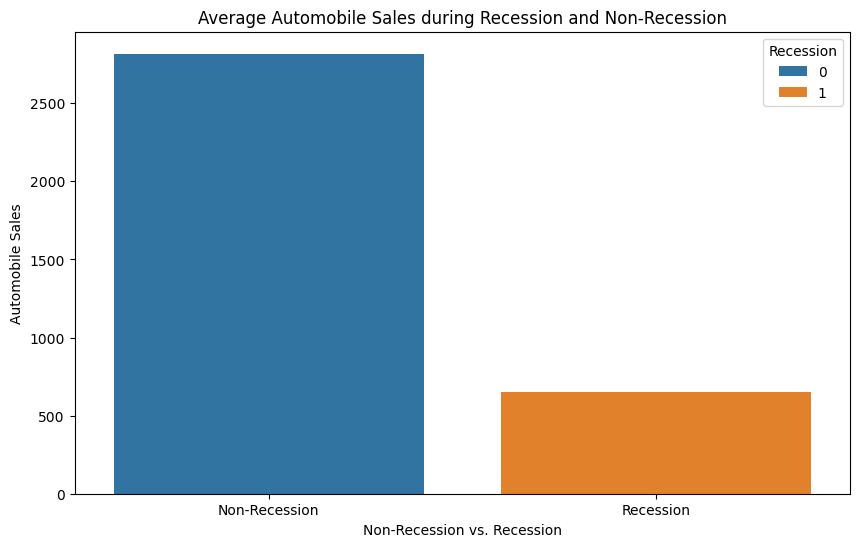

In [9]:
new_df = df.groupby('Recession')['Automobile_Sales'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='Recession',y='Automobile_Sales', hue='Recession', data = new_df)
plt.xlabel('Non-Recession vs. Recession')
plt.ylabel('Automobile Sales')
plt.title('Average Automobile Sales during Recession and Non-Recession')
plt.xticks(ticks=[0,1], labels =['Non-Recession','Recession'])
plt.show()

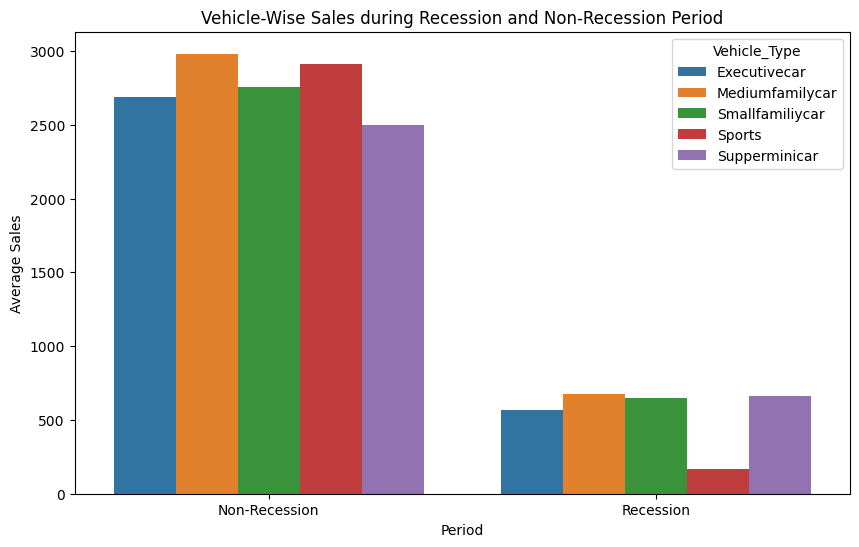

In [10]:

recession_data = df[df['Recession'] == 1]

group_data=df.groupby(['Recession','Vehicle_Type'])['Automobile_Sales'].mean().reset_index()

    
sales_by_vehicle_type = recession_data.groupby('Vehicle_Type')['Automobile_Sales'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Recession', y='Automobile_Sales', hue='Vehicle_Type', data=group_data)
plt.xticks(ticks=[0, 1], labels=['Non-Recession', 'Recession'])
plt.xlabel('Period')
plt.ylabel('Average Sales')
plt.title('Vehicle-Wise Sales during Recession and Non-Recession Period')

plt.show()

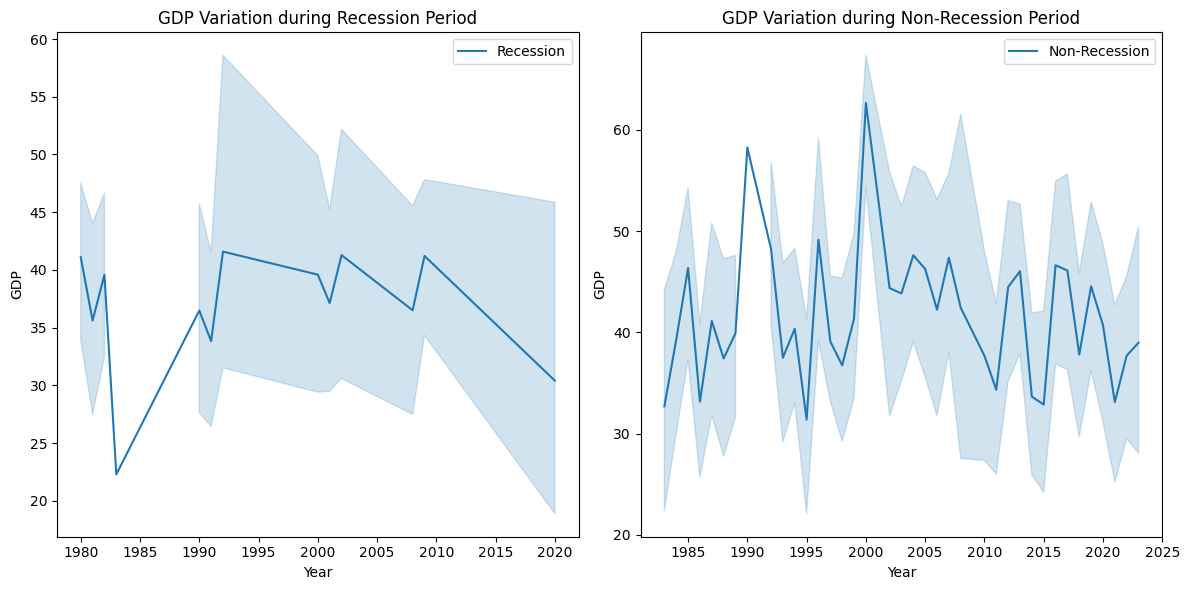

In [12]:
recession_data = df[df['Recession'] ==1]
non_recession_data = df[df['Recession']== 0]

figure = plt.figure(figsize=(12,6))

ax = figure.add_subplot(1,2,1)
ax1 = figure.add_subplot(1,2,2)

plt.subplot(1,2,1)
sns.lineplot(x='Year',y='GDP', data = recession_data, label='Recession', ax = ax)
ax.set_xlabel('Year')
ax.set_ylabel('GDP')
ax.set_title('GDP Variation during Recession Period')

plt.subplot(1,2,2)
sns.lineplot(x='Year',y='GDP', data = non_recession_data, label='Non-Recession', ax = ax1)
ax1.set_xlabel('Year')
ax1.set_ylabel('GDP')
ax1.set_title('GDP Variation during Non-Recession Period')

plt.tight_layout()
plt.show()

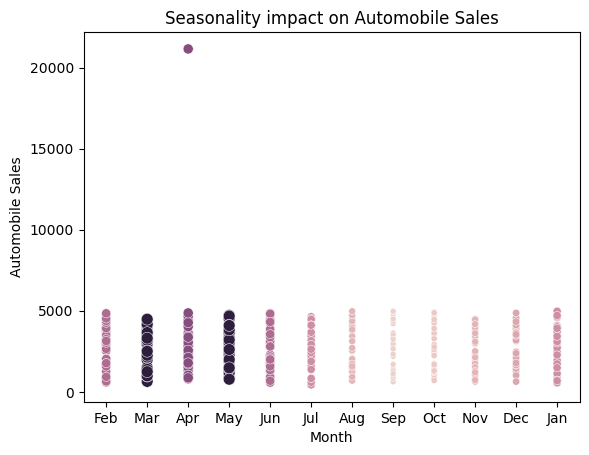

In [16]:
non_recession_data = df[df['Recession']== 0]

size = non_recession_data['Seasonality_Weight']

sns.scatterplot(data= non_recession_data, x='Month',y='Automobile_Sales',size=size,hue ='Seasonality_Weight', legend=False)

plt.xlabel('Month')
plt.ylabel('Automobile Sales')
plt.title('Seasonality impact on Automobile Sales')

plt.show()

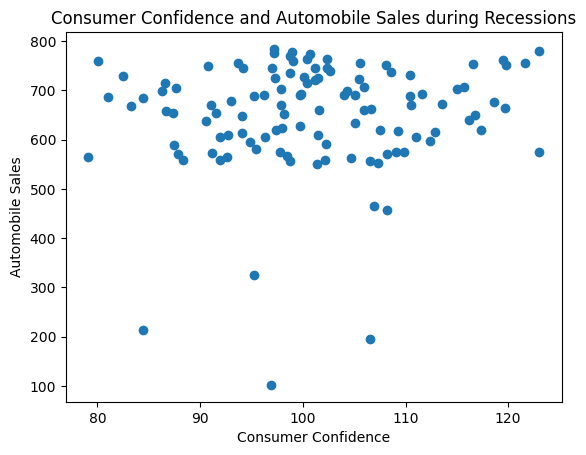

In [25]:
recession_data1 = df[df['Recession'] == 1]
non_recession_data1 = df[df['Recession']== 0]

plt.scatter(recession_data['Consumer_Confidence'],recession_data1['Automobile_Sales'])
            
plt.xlabel('Consumer Confidence')
plt.ylabel('Automobile Sales')
plt.title('Consumer Confidence and Automobile Sales during Recessions')
plt.show()

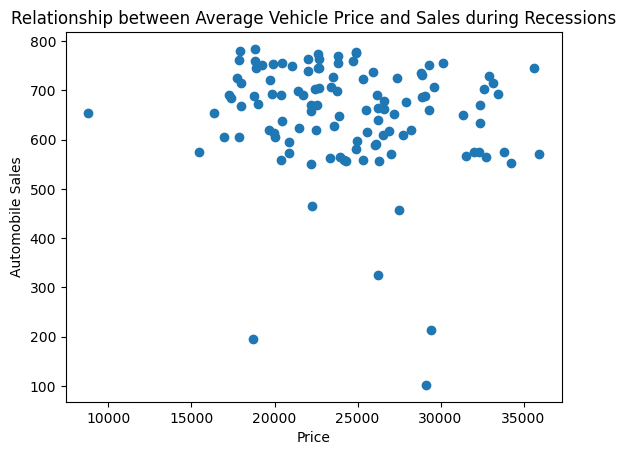

In [26]:
recession_data1 = df[df['Recession'] == 1]
non_recession_data = df[df['Recession']== 0]

plt.scatter(recession_data['Price'],recession_data1['Automobile_Sales'])
            
plt.xlabel('Price')
plt.ylabel('Automobile Sales')
plt.title('Relationship between Average Vehicle Price and Sales during Recessions')
plt.show()

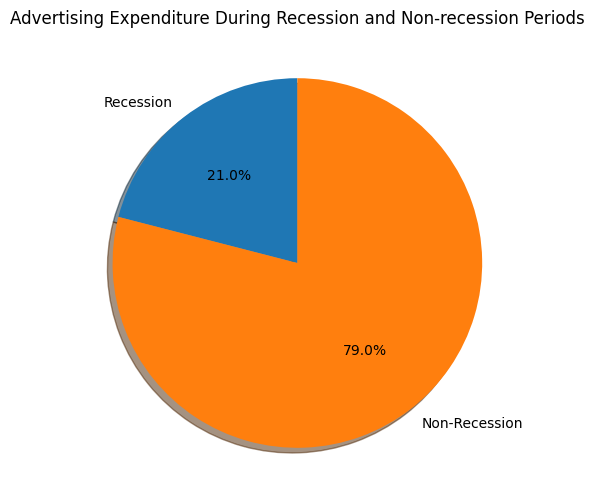

In [29]:
recession_data2 = df[df['Recession'] == 1]
non_recession_data2 = df[df['Recession']== 0]

recession_total = recession_data2['Advertising_Expenditure'].sum()
non_recession_total = non_recession_data2['Advertising_Expenditure'].sum()

plt.figure(figsize=(8,6))

labels = ['Recession','Non-Recession']
sizes = [recession_total,non_recession_total]
plt.pie(sizes, labels = labels, autopct='%1.1f%%',
        shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9},startangle=90)

plt.title('Advertising Expenditure During Recession and Non-recession Periods')

plt.show()

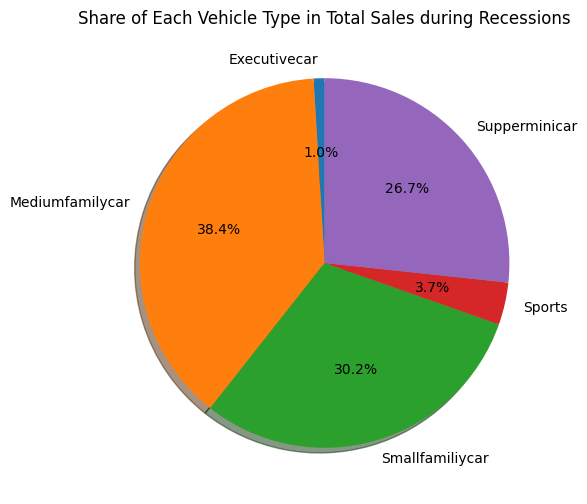

In [35]:
recession_data3 = df[df['Recession'] == 1]

Vec_sales = recession_data3.groupby('Vehicle_Type')['Advertising_Expenditure'].sum()

plt.figure(figsize=(8,6))

labels = Vec_sales.index
sizes = Vec_sales.values
plt.pie(sizes, labels = labels, autopct='%1.1f%%',
        shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9},startangle=90)

plt.title('Share of Each Vehicle Type in Total Sales during Recessions')

plt.show()

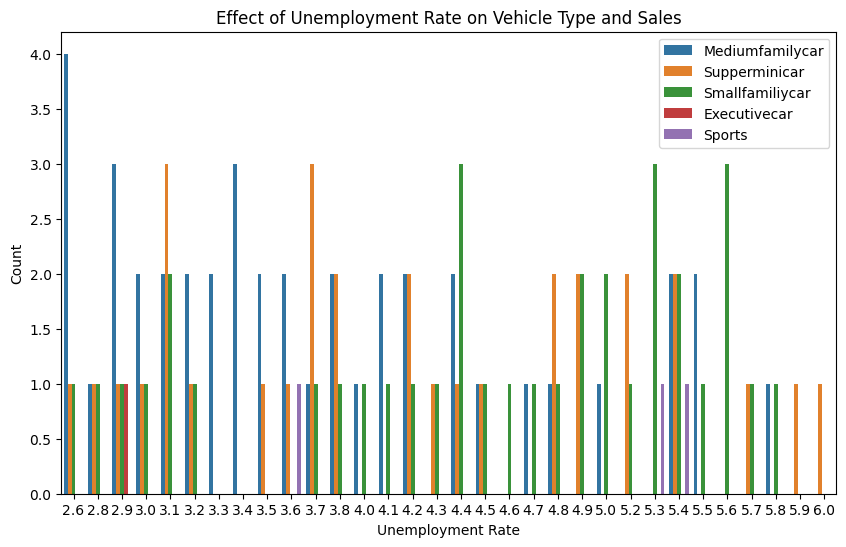

In [36]:
recession_data3 = df[df['Recession'] == 1]

plt.figure(figsize=(10,6))

sns.countplot( data = recession_data3, x='unemployment_rate',hue='Vehicle_Type')

plt.xlabel('Unemployment Rate')
plt.ylabel('Count')
plt.title('Effect of Unemployment Rate on Vehicle Type and Sales')
plt.legend(loc='upper right')
plt.show()

In [30]:
from pyodide.http import pyfetch

async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, "wb") as f:
            f.write(await response.bytes())

path = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/us-states.json'
await download(path, "us-states.json")

filename = "us-states.json"

In [40]:
recession_data4 = recession_data3[recession_data3['Recession'] == 1]

    # Calculate the total sales by city
sales_by_city = recession_data.groupby('City')['Automobile_Sales'].sum().reset_index()

    # Create a base map centered on the United States
map1 = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

    # Create a choropleth layer using Folium
choropleth = folium.Choropleth(
    geo_data= 'us-states.json',  # GeoJSON file with state boundaries
    data=sales_by_city,
    columns=['City', 'Automobile_Sales'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Automobile Sales during Recession'
    ).add_to(map1)


    # Add tooltips to the choropleth layer
choropleth.geojson.add_child(
        folium.features.GeoJsonTooltip(['name'], labels=True)
    )

    # Display the map
map1

In [1]:
!pip install sqlalchemy==1.3.9
!pip install ibm_db
!pip install ibm_db_sa
!pip install ipython-sql

In [2]:
%load_ext sql

In [3]:
%sql ibm_db_sa://xcg80731:Z0Aq5Vwa8fZKzZ60@ba99a9e6-d59e-4883-8fc0-d6a8c9f7a08f.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud:31321/bludb?security=SSL

'Connected: xcg80731@bludb'

In [4]:
%sql SELECT TABSCHEMA, TABNAME, CREATE_TIME FROM SYSCAT.TABLES WHERE TABSCHEMA='XCG80731';

 * ibm_db_sa://xcg80731:***@ba99a9e6-d59e-4883-8fc0-d6a8c9f7a08f.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud:31321/bludb
Done.


[('XCG80731', 'SPACEXTBL', datetime.datetime(2021, 9, 16, 23, 15, 7, 510732))]

In [5]:
%%sql
SELECT DISTINCT LAUNCH_SITE
FROM SPACEXTBL;

 * ibm_db_sa://xcg80731:***@ba99a9e6-d59e-4883-8fc0-d6a8c9f7a08f.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud:31321/bludb
Done.


[('CCAFS LC-40',), ('CCAFS SLC-40',), ('KSC LC-39A',), ('VAFB SLC-4E',)]

In [6]:
%%sql
SELECT COUNT(*) LAUNCH_SITE
FROM SPACEXTBL
WHERE LAUNCH_SITE = 'CCAFS LC-40';

 * ibm_db_sa://xcg80731:***@ba99a9e6-d59e-4883-8fc0-d6a8c9f7a08f.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud:31321/bludb
Done.


[(26,)]

In [7]:
%%sql
SELECT COUNT(*) LAUNCH_SITE
FROM SPACEXTBL
WHERE LAUNCH_SITE = 'CCAFS SLC-40';

 * ibm_db_sa://xcg80731:***@ba99a9e6-d59e-4883-8fc0-d6a8c9f7a08f.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud:31321/bludb
Done.


[(34,)]

In [8]:
# It seems the provided dataset is flawed,
# launch sites 'CCAFS SLC-40' and 'CCAFS LC-40' are the same place

In [9]:
%%sql
SELECT LAUNCH_SITE
FROM SPACEXTBL
WHERE LAUNCH_SITE LIKE 'CCA%'
LIMIT 5;

 * ibm_db_sa://xcg80731:***@ba99a9e6-d59e-4883-8fc0-d6a8c9f7a08f.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud:31321/bludb
Done.


[('CCAFS LC-40',),
 ('CCAFS LC-40',),
 ('CCAFS LC-40',),
 ('CCAFS LC-40',),
 ('CCAFS LC-40',)]

In [10]:
%%sql
SELECT SUM(PAYLOAD_MASS__KG_)
FROM SPACEXTBL
WHERE Customer = 'NASA (CRS)';

 * ibm_db_sa://xcg80731:***@ba99a9e6-d59e-4883-8fc0-d6a8c9f7a08f.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud:31321/bludb
Done.


[(45596,)]

In [11]:
%%sql
SELECT AVG(PAYLOAD_MASS__KG_)
FROM SPACEXTBL
WHERE Booster_Version LIKE 'F9 v1.0%';

 * ibm_db_sa://xcg80731:***@ba99a9e6-d59e-4883-8fc0-d6a8c9f7a08f.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud:31321/bludb
Done.


[(340,)]

In [30]:
%%sql
SELECT MIN(Date)
FROM SPACEXTBL
WHERE Landing__Outcome = 'Success (ground pad)';

 * ibm_db_sa://xcg80731:***@ba99a9e6-d59e-4883-8fc0-d6a8c9f7a08f.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud:31321/bludb
Done.


[(datetime.date(2015, 12, 22),)]

In [33]:
%%sql
SELECT BOOSTER_VERSION
FROM SPACEXTBL
WHERE LANDING__OUTCOME = 'Success (drone ship)'
    AND 4000 < PAYLOAD_MASS__KG_ < 6000;

 * ibm_db_sa://xcg80731:***@ba99a9e6-d59e-4883-8fc0-d6a8c9f7a08f.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud:31321/bludb
Done.


[('F9 FT B1021.1',),
 ('F9 FT B1023.1',),
 ('F9 FT  B1029.2',),
 ('F9 FT B1038.1',),
 ('F9 B4 B1042.1',),
 ('F9 B4 B1045.1',),
 ('F9 B5  B1046.1',)]

In [44]:
%%sql
SELECT MISSION_OUTCOME, COUNT(MISSION_OUTCOME) AS TOTAL_NUMBER
FROM SPACEXTBL
GROUP BY MISSION_OUTCOME;

 * ibm_db_sa://xcg80731:***@ba99a9e6-d59e-4883-8fc0-d6a8c9f7a08f.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud:31321/bludb
Done.


[('Failure (in flight)', 1),
 ('Success', 99),
 ('Success (payload status unclear)', 1)]

In [57]:
%%sql
SELECT DISTINCT BOOSTER_VERSION
FROM SPACEXTBL
WHERE PAYLOAD_MASS__KG_ = (
    SELECT MAX(PAYLOAD_MASS__KG_)
    FROM SPACEXTBL);

 * ibm_db_sa://xcg80731:***@ba99a9e6-d59e-4883-8fc0-d6a8c9f7a08f.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud:31321/bludb
Done.


[('F9 B5 B1048.4',),
 ('F9 B5 B1048.5',),
 ('F9 B5 B1049.4',),
 ('F9 B5 B1049.5',),
 ('F9 B5 B1049.7',),
 ('F9 B5 B1051.3',),
 ('F9 B5 B1051.4',),
 ('F9 B5 B1051.6',),
 ('F9 B5 B1056.4',),
 ('F9 B5 B1058.3',),
 ('F9 B5 B1060.2',),
 ('F9 B5 B1060.3',)]

In [62]:
%%sql
SELECT LANDING__OUTCOME, BOOSTER_VERSION, LAUNCH_SITE
FROM SPACEXTBL
WHERE Landing__Outcome = 'Failure (drone ship)'
    AND YEAR(DATE) = 2015;

 * ibm_db_sa://xcg80731:***@ba99a9e6-d59e-4883-8fc0-d6a8c9f7a08f.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud:31321/bludb
Done.


[('Failure (drone ship)', 'F9 v1.1 B1012', 'CCAFS LC-40'),
 ('Failure (drone ship)', 'F9 v1.1 B1015', 'CCAFS LC-40')]

In [70]:
%%sql
SELECT LANDING__OUTCOME, COUNT(LANDING__OUTCOME) AS TOTAL_NUMBER
FROM SPACEXTBL
WHERE DATE BETWEEN '2010-06-04' AND '2017-03-20'
GROUP BY LANDING__OUTCOME
ORDER BY TOTAL_NUMBER DESC

 * ibm_db_sa://xcg80731:***@ba99a9e6-d59e-4883-8fc0-d6a8c9f7a08f.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud:31321/bludb
Done.


[('No attempt', 10),
 ('Failure (drone ship)', 5),
 ('Success (drone ship)', 5),
 ('Controlled (ocean)', 3),
 ('Success (ground pad)', 3),
 ('Failure (parachute)', 2),
 ('Uncontrolled (ocean)', 2),
 ('Precluded (drone ship)', 1)]

In [ ]:
# note that this notebook is not currently working correctly, there is a bug with the proxy config

In [1]:
!pip install dash
!pip install dash==1.19.0
!pip install jupyter_dash
!pip install --upgrade plotly

In [2]:
from jupyter_dash.comms import _send_jupyter_config_comm_request
_send_jupyter_config_comm_request()

In [3]:
import pandas as pd
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash
import plotly.graph_objects as go

In [4]:
!pip list

Package                         Version
------------------------------- ---------
absl-py                         0.14.0
ansi2html                       0.0.0
argcomplete                     1.12.3
argon2-cffi                     21.1.0
astor                           0.8.1
attrs                           21.2.0
autobahn                        21.3.1
Automat                         20.2.0
backcall                        0.2.0
backports.functools-lru-cache   1.6.4
basemap                         1.2.0
bleach                          4.1.0
boto3                           1.7.62
botocore                        1.10.84
branca                          0.4.2
Brotli                          1.0.9
brotlipy                        0.7.0
certifi                         2021.5.30
cffi                            1.14.6
chardet                         4.0.0
charset-normalizer              2.0.0
click                           8.0.1
cloudpickle                     2.0.0
colorama                      

In [ ]:
# !jupyter labextension list

In [ ]:
# notebook hangs if I run the following command 
JupyterDash.infer_jupyter_proxy_config()

In [ ]:
# needs to be run again in a separate cell due to a jupyterdash bug
JupyterDash.infer_jupyter_proxy_config()

In [5]:
spacex_df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_dash.csv')

In [6]:
# skeleton Dash app to be completed in this lab, downloaded from:
# https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/spacex_dash_app.py
# redundant lines commented out

# Import required libraries
# import pandas as pd
# import dash
# import dash_html_components as html
# import dash_core_components as dcc
# from dash.dependencies import Input, Output
import plotly.express as px

# Read the airline data into pandas dataframe
# spacex_df = pd.read_csv("spacex_launch_dash.csv")
max_payload = spacex_df['Payload Mass (kg)'].max()
min_payload = spacex_df['Payload Mass (kg)'].min()

# Create a dash application
# app = dash.Dash(__name__) # commented out as we are using JupyterDash instead of dash.Dash
app = JupyterDash(__name__)

# Create an app layout
app.layout = html.Div(children=[html.H1('SpaceX Launch Records Dashboard',
                                        style={'textAlign': 'center', 'color': '#503D36',
                                               'font-size': 40}),
                                # TASK 1: Add a dropdown list to enable Launch Site selection
                                # The default select value is for ALL sites
                                # dcc.Dropdown(id='site-dropdown',...)
                                dcc.Dropdown(id='site-dropdown',
                                             options=[
                                                     {'label': 'All Sites', 'value': 'ALL'},
                                                     {'label': 'CCAFS LC-40', 'value': 'CCAFS LC-40'},
                                                     {'label': 'VAFB SLC-4E', 'value': 'VAFB SLC-4E'},
                                                     {'label': 'KSC LC-39A', 'value': 'KSC LC-39A'},
                                                     {'label': 'CCAFS SLC-40', 'value': 'CCAFS SLC-40'}
                                                     ],
                                             value='ALL',
                                             placeholder='Select a Launch Site here',
                                             searchable=True
                                             # style={'width':'80%','padding':'3px','font-size':'20px','text-align-last':'center'}
                                             ),
                                html.Br(),

                                # TASK 2: Add a pie chart to show the total successful launches count for all sites
                                # If a specific launch site was selected, show the Success vs. Failed counts for the site
                                html.Div(dcc.Graph(id='success-pie-chart')),
                                html.Br(),

                                html.P("Payload range (Kg):"),
                                # TASK 3: Add a slider to select payload range
                                #dcc.RangeSlider(id='payload-slider',...)
                                dcc.RangeSlider(id='payload-slider',
                                                min=0,
                                                max=10000,
                                                step=1000,
                                                value=[min_payload, max_payload]
                                                ),

                                # TASK 4: Add a scatter chart to show the correlation between payload and launch success
                                html.Div(dcc.Graph(id='success-payload-scatter-chart')),
                                ])

# TASK 2:
# Add a callback function for `site-dropdown` as input, `success-pie-chart` as output
@app.callback(Output(component_id='success-pie-chart', component_property='figure'),
              Input(component_id='site-dropdown', component_property='value'))
def get_pie_chart(entered_site):
    filtered_df = spacex_df
    if entered_site == 'ALL':
        fig = px.pie(filtered_df, values='class', 
        names='Launch Site', 
        title='Success Count for all launch sites')
        return fig
    else:
        # return the outcomes piechart for a selected site
        filtered_df=spacex_df[spacex_df['Launch Site']== entered_site]
        filtered_df=filtered_df.groupby(['Launch Site','class']).size().reset_index(name='class count')
        fig=px.pie(filtered_df,values='class count',names='class',title=f"Total Success Launches for site {entered_site}")
        return fig

# TASK 4:
# Add a callback function for `site-dropdown` and `payload-slider` as inputs, `success-payload-scatter-chart` as output
@app.callback(Output(component_id='success-payload-scatter-chart',component_property='figure'),
                [Input(component_id='site-dropdown',component_property='value'),
                Input(component_id='payload-slider',component_property='value')])
def scatter(entered_site,payload):
    filtered_df = spacex_df[spacex_df['Payload Mass (kg)'].between(payload[0],payload[1])]
    # thought reusing filtered_df may cause issues, but tried it out of curiosity and it seems to be working fine
    
    if entered_site=='ALL':
        fig=px.scatter(filtered_df,x='Payload Mass (kg)',y='class',color='Booster Version Category',title='Success count on Payload mass for all sites')
        return fig
    else:
        fig=px.scatter(filtered_df[filtered_df['Launch Site']==entered_site],x='Payload Mass (kg)',y='class',color='Booster Version Category',title=f"Success count on Payload mass for site {entered_site}")
        return fig

# Run the app
if __name__ == '__main__':
    app.run_server(mode='inline', host='localhost')

In [1]:
# Requests allows us to make HTTP requests which we will use to get data from an API
import requests
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Datetime is a library that allows us to represent dates
import datetime

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

In [2]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

In [3]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
        response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
        Longitude.append(response['longitude'])
        Latitude.append(response['latitude'])
        LaunchSite.append(response['name'])

In [4]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

In [5]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

In [6]:
spacex_url="https://api.spacexdata.com/v4/launches/past"

In [7]:
response = requests.get(spacex_url)

In [8]:
print(response.content)

b'[{"fairings":{"reused":false,"recovery_attempt":false,"recovered":false,"ships":[]},"links":{"patch":{"small":"https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png","large":"https://images2.imgbox.com/40/e3/GypSkayF_o.png"},"reddit":{"campaign":null,"launch":null,"media":null,"recovery":null},"flickr":{"small":[],"original":[]},"presskit":null,"webcast":"https://www.youtube.com/watch?v=0a_00nJ_Y88","youtube_id":"0a_00nJ_Y88","article":"https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html","wikipedia":"https://en.wikipedia.org/wiki/DemoSat"},"static_fire_date_utc":"2006-03-17T00:00:00.000Z","static_fire_date_unix":1142553600,"net":false,"window":0,"rocket":"5e9d0d95eda69955f709d1eb","success":false,"failures":[{"time":33,"altitude":null,"reason":"merlin engine failure"}],"details":"Engine failure at 33 seconds and loss of vehicle","crew":[],"ships":[],"capsules":[],"payloads":["5eb0e4b5b6c3bb0006eeb1e1"],"launchpad":"5e9e4502f5090995de566f86","flight_number":1,"name

In [9]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

In [10]:
response.status_code

200

In [11]:
# Use json_normalize meethod to convert the json result into a dataframe
data = pd.json_normalize(response.json())

In [12]:
# Get the head of the dataframe
data.head()

static_fire_date_utc  static_fire_date_unix    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False     0.0   
1                      None                    NaN  False     0.0   
2                      None                    NaN  False     0.0   
3  2008-09-20T00:00:00.000Z           1.221869e+09  False     0.0   
4                      None                    NaN  False     0.0   

                     rocket  success  \
0  5e9d0d95eda69955f709d1eb    False   
1  5e9d0d95eda69955f709d1eb    False   
2  5e9d0d95eda69955f709d1eb    False   
3  5e9d0d95eda69955f709d1eb     True   
4  5e9d0d95eda69955f709d1eb     True   

                                                                                                            failures  \
0                                                [{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]   
1            [{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]   
2  [{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]   
3                                                                                                                 []   
4                                                                                                                 []   

                                                                                                                                                                                details  \
0                                                                                                                                      Engine failure at 33 seconds and loss of vehicle   
1  Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage   
2                                                                                                                  Residual stage 1 thrust led to collision between stage 1 and stage 2   
3                        Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1   
4                                                                                                                                                                                  None   

  crew ships capsules                                              payloads  \
0   []    []       []                            [5eb0e4b5b6c3bb0006eeb1e1]   
1   []    []       []                            [5eb0e4b6b6c3bb0006eeb1e2]   
2   []    []       []  [5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]   
3   []    []       []                            [5eb0e4b7b6c3bb0006eeb1e5]   
4   []    []       []                            [5eb0e4b7b6c3bb0006eeb1e6]   

                  launchpad  flight_number         name  \
0  5e9e4502f5090995de566f86              1    FalconSat   
1  5e9e4502f5090995de566f86              2      DemoSat   
2  5e9e4502f5090995de566f86              3  Trailblazer   
3  5e9e4502f5090995de566f86              4       RatSat   
4  5e9e4502f5090995de566f86              5     RazakSat   

                   date_utc   date_unix                 date_local  \
0  2006-03-24T22:30:00.000Z  1143239400  2006-03-25T10:30:00+12:00   
1  2007-03-21T01:10:00.000Z  1174439400  2007-03-21T13:10:00+12:00   
2  2008-08-03T03:34:00.000Z  1217734440  2008-08-03T15:34:00+12:00   
3  2008-09-28T23:15:00.000Z  1222643700  2008-09-28T11:15:00+12:00   
4  2009-07-13T03:35:00.000Z  1247456100  2009-07-13T15:35:00+12:00   

  date_precision  upcoming  \
0           hour     False   
1           hour     False   
2           hour     False   
3           hour     False   
4           hour     False   

                                                                           

In [13]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

In [14]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [15]:
BoosterVersion

[]

In [16]:
# Call getBoosterVersion
getBoosterVersion(data)

In [17]:
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

In [18]:
# Call getLaunchSite
getLaunchSite(data)

In [19]:
# Call getPayloadData
getPayloadData(data)

In [20]:
# Call getCoreData
getCoreData(data)

In [21]:
launch_dict = {
'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}


In [22]:
# Create a data from launch_dict
df = pd.DataFrame.from_dict(launch_dict)

In [23]:
# Show the head of the dataframe
df.head()

FlightNumber        Date BoosterVersion  PayloadMass Orbit  \
0             1  2006-03-24       Falcon 1         20.0   LEO   
1             2  2007-03-21       Falcon 1          NaN   LEO   
2             4  2008-09-28       Falcon 1        165.0   LEO   
3             5  2009-07-13       Falcon 1        200.0   LEO   
4             6  2010-06-04       Falcon 9          NaN   LEO   

        LaunchSite    Outcome  Flights  GridFins  Reused   Legs LandingPad  \
0  Kwajalein Atoll  None None        1     False   False  False       None   
1  Kwajalein Atoll  None None        1     False   False  False       None   
2  Kwajalein Atoll  None None        1     False   False  False       None   
3  Kwajalein Atoll  None None        1     False   False  False       None   
4     CCSFS SLC 40  None None        1     False   False  False       None   

   Block  ReusedCount    Serial   Longitude   Latitude  
0    NaN            0  Merlin1A  167.743129   9.047721  
1    NaN            0  Merlin2A  167.743129   9.047721  
2    NaN            0  Merlin2C  167.743129   9.047721  
3    NaN            0  Merlin3C  167.743129   9.047721  
4    1.0            0     B0003  -80.577366  28.561857

In [24]:
data_falcon9 = df[df['BoosterVersion']!='Falcon 1']

In [25]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
4              1  2010-06-04       Falcon 9          NaN   LEO  CCSFS SLC 40   
5              2  2012-05-22       Falcon 9        525.0   LEO  CCSFS SLC 40   
6              3  2013-03-01       Falcon 9        677.0   ISS  CCSFS SLC 40   
7              4  2013-09-29       Falcon 9        500.0    PO   VAFB SLC 4E   
8              5  2013-12-03       Falcon 9       3170.0   GTO  CCSFS SLC 40   
..           ...         ...            ...          ...   ...           ...   
89            86  2020-09-03       Falcon 9      15600.0  VLEO    KSC LC 39A   
90            87  2020-10-06       Falcon 9      15600.0  VLEO    KSC LC 39A   
91            88  2020-10-18       Falcon 9      15600.0  VLEO    KSC LC 39A   
92            89  2020-10-24       Falcon 9      15600.0  VLEO  CCSFS SLC 40   
93            90  2020-11-05       Falcon 9       3681.0   MEO  CCSFS SLC 40   

        Outcome  Flights  GridFins  Reused   Legs                LandingPad  \
4     None None        1     False   False  False                      None   
5     None None        1     False   False  False                      None   
6     None None        1     False   False  False                      None   
7   False Ocean        1     False   False  False                      None   
8     None None        1     False   False  False                      None   
..          ...      ...       ...     ...    ...                       ...   
89    True ASDS        2      True    True   True  5e9e3032383ecb6bb234e7ca   
90    True ASDS        3      True    True   True  5e9e3032383ecb6bb234e7ca   
91    True ASDS        6      True    True   True  5e9e3032383ecb6bb234e7ca   
92    True ASDS        3      True    True   True  5e9e3033383ecbb9e534e7cc   
93    True ASDS        1      True   False   True  5e9e3032383ecb6bb234e7ca   

    Block  ReusedCount Serial   Longitude   Latitude  
4     1.0            0  B0003  -80.577366  28.561857  
5     1.0            0  B0005  -80.577366  28.561857  
6     1.0            0  B0007  -80.577366  28.561857  
7     1.0            0  B1003 -120.610829  34.632093  
8     1.0            0  B1004  -80.577366  28.561857  
..    ...          ...    ...         ...        ...  
89    5.0            7  B1060  -80.603956  28.608058  
90    5.0            7  B1058  -80.603956  28.608058  
91    5.0            9  B1051  -80.603956  28.608058  
92    5.0            7  B1060  -80.577366  28.561857  
93    5.0            1  B1062  -80.577366  28.561857  

[90 rows x 17 columns]

In [26]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [29]:
# Calculate the mean value of PayloadMass column
payloadmassavg = data_falcon9['PayloadMass'].mean()
# Replace the np.nan values with its mean value
data_falcon9['PayloadMass'].replace(np.nan, payloadmassavg, inplace=True)

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [30]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [1]:
!pip3 install beautifulsoup4
!pip3 install requests

In [2]:
import sys
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

In [3]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    


In [4]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

In [5]:
# use requests.get() method with the provided static_url
# assign the response to a object
data  = requests.get(static_url).text

In [6]:
# Use BeautifulSoup() to create a BeautifulSoup object from a response text content
soup = BeautifulSoup(data, 'html5lib')

In [7]:
# Use soup.title attribute
print(soup.title)

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>


In [8]:
# Use the find_all function in the BeautifulSoup object, with element type `table`
# Assign the result to a list called `html_tables`
html_tables = soup.find_all('table')

In [9]:
# Let's print the third table and check its content
first_launch_table = html_tables[2]
print(first_launch_table)

<table class="wikitable plainrowheaders collapsible" style="width: 100%;">
<tbody><tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11">[b]</a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12">[c]</a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 9 first-stage landing tests">Booster<br/>landing</a>
</th></tr>
<tr>
<th rowspan="2" scope="row" style="text-align:center;">1
</th>
<td>

In [10]:
column_names = []
# Apply find_all() function with `th` element on first_launch_table
# Iterate each th element and apply the provided extract_column_from_header() to get a column name
# Append the Non-empty column name (`if name is not None and len(name) > 0`) into a list called column_names
for row in first_launch_table.find_all('th'):
    name = extract_column_from_header(row)
    if (name != None and len(name) > 0):
        column_names.append(name)

In [11]:
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


In [12]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

In [13]:
extracted_row = 0
#Extract each table 
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row 
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number 
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element 
        row=rows.find_all('td')
        #if it is number save cells in a dictonary 
        if flag:
            extracted_row += 1
            # Flight Number value
            # TODO: Append the flight_number into launch_dict with key `Flight No.`
            launch_dict['Flight No.'].append(flight_number) #TODO-1
            #print(flight_number)
            datatimelist=date_time(row[0])
            
            # Date value
            # TODO: Append the date into launch_dict with key `Date`
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date) #TODO-2
            #print(date)
            
            # Time value
            # TODO: Append the time into launch_dict with key `Time`
            time = datatimelist[1]
            launch_dict['Time'].append(time) #TODO-3
            #print(time)
              
            # Booster version
            # TODO: Append the bv into launch_dict with key `Version Booster`
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            launch_dict['Version Booster'].append(bv) #TODO-4
            #print(bv)
            
            # Launch Site
            # TODO: Append the bv into launch_dict with key `Launch site`
            launch_site = row[2].a.string
            launch_dict['Launch site'].append(launch_site) #TODO-5
            #print(launch_site)
            
            # Payload
            # TODO: Append the payload into launch_dict with key `Payload`
            payload = row[3].a.string
            launch_dict['Payload'].append(payload) #TODO-6
            #print(payload)
            
            # Payload Mass
            # TODO: Append the payload_mass into launch_dict with key `Payload mass`
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass) #TODO-7
            #print(payload)
            
            # Orbit
            # TODO: Append the orbit into launch_dict with key `Orbit`
            orbit = row[5].a.string
            launch_dict['Orbit'].append(orbit) #TODO-8
            #print(orbit)
            
            # Customer
            # TODO: Append the customer into launch_dict with key `Customer`
            customer = row[6].text.strip()
            launch_dict['Customer'].append(customer) #TODO-9
            #print(customer)
            
            # Launch outcome
            # TODO: Append the launch_outcome into launch_dict with key `Launch outcome`
            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch outcome'].append(launch_outcome) #TODO-10
            #print(launch_outcome)
            
            # Booster landing
            # TODO: Append the launch_outcome into launch_dict with key `Booster landing`
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing) #TODO-11
            #print(booster_landing)
            

In [15]:
df=pd.DataFrame(launch_dict)

In [18]:
df

Flight No. Launch site                               Payload Payload mass  \
0            1       CCAFS  Dragon Spacecraft Qualification Unit            0   
1            2       CCAFS                                Dragon            0   
2            3       CCAFS                                Dragon       525 kg   
3            4       CCAFS                          SpaceX CRS-1     4,700 kg   
4            5       CCAFS                          SpaceX CRS-2     4,877 kg   
..         ...         ...                                   ...          ...   
116        117       CCSFS                              Starlink    15,600 kg   
117        118         KSC                              Starlink   ~14,000 kg   
118        119       CCSFS                              Starlink    15,600 kg   
119        120         KSC                         SpaceX CRS-22     3,328 kg   
120        121       CCSFS                                 SXM-8     7,000 kg   

    Orbit                        Customer Launch outcome Version Booster  \
0     LEO                          SpaceX      Success\n  F9 v1.0B0003.1   
1     LEO                NASA (COTS)\nNRO        Success  F9 v1.0B0004.1   
2     LEO                     NASA (COTS)        Success  F9 v1.0B0005.1   
3     LEO                      NASA (CRS)      Success\n  F9 v1.0B0006.1   
4     LEO                      NASA (CRS)      Success\n  F9 v1.0B0007.1   
..    ...                             ...            ...             ...   
116   LEO                          SpaceX      Success\n   F9 B5B1051.10   
117   LEO  SpaceX Capella Space and Tyvak      Success\n    F9 B5B1058.8   
118   LEO                          SpaceX      Success\n    F9 B5B1063.2   
119   LEO                      NASA (CRS)      Success\n    F9 B5B1067.1   
120   GTO                       Sirius XM      Success\n           F9 B5   

    Booster landing             Date   Time  
0           Failure      4 June 2010  18:45  
1           Failure  8 December 2010  15:43  
2      No attempt\n      22 May 2012  07:44  
3        No attempt   8 October 2012  00:35  
4      No attempt\n     1 March 2013  15:10  
..              ...              ...    ...  
116         Success       9 May 2021  06:42  
117         Success      15 May 2021  22:56  
118         Success      26 May 2021  18:59  
119         Success      3 June 2021  17:29  
120         Success      6 June 2021  04:26  

[121 rows x 11 columns]

In [1]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np

In [2]:
df=pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv")
df.head(10)

FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
0             1  2010-06-04       Falcon 9  6104.959412   LEO  CCAFS SLC 40   
1             2  2012-05-22       Falcon 9   525.000000   LEO  CCAFS SLC 40   
2             3  2013-03-01       Falcon 9   677.000000   ISS  CCAFS SLC 40   
3             4  2013-09-29       Falcon 9   500.000000    PO   VAFB SLC 4E   
4             5  2013-12-03       Falcon 9  3170.000000   GTO  CCAFS SLC 40   
5             6  2014-01-06       Falcon 9  3325.000000   GTO  CCAFS SLC 40   
6             7  2014-04-18       Falcon 9  2296.000000   ISS  CCAFS SLC 40   
7             8  2014-07-14       Falcon 9  1316.000000   LEO  CCAFS SLC 40   
8             9  2014-08-05       Falcon 9  4535.000000   GTO  CCAFS SLC 40   
9            10  2014-09-07       Falcon 9  4428.000000   GTO  CCAFS SLC 40   

       Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
0    None None        1     False   False  False        NaN    1.0   
1    None None        1     False   False  False        NaN    1.0   
2    None None        1     False   False  False        NaN    1.0   
3  False Ocean        1     False   False  False        NaN    1.0   
4    None None        1     False   False  False        NaN    1.0   
5    None None        1     False   False  False        NaN    1.0   
6   True Ocean        1     False   False   True        NaN    1.0   
7   True Ocean        1     False   False   True        NaN    1.0   
8    None None        1     False   False  False        NaN    1.0   
9    None None        1     False   False  False        NaN    1.0   

   ReusedCount Serial   Longitude   Latitude  
0            0  B0003  -80.577366  28.561857  
1            0  B0005  -80.577366  28.561857  
2            0  B0007  -80.577366  28.561857  
3            0  B1003 -120.610829  34.632093  
4            0  B1004  -80.577366  28.561857  
5            0  B1005  -80.577366  28.561857  
6            0  B1006  -80.577366  28.561857  
7            0  B1007  -80.577366  28.561857  
8            0  B1008  -80.577366  28.561857  
9            0  B1011  -80.577366  28.561857

In [3]:
df.isnull().sum()/df.count()*100

FlightNumber       0.000
Date               0.000
BoosterVersion     0.000
PayloadMass        0.000
Orbit              0.000
LaunchSite         0.000
Outcome            0.000
Flights            0.000
GridFins           0.000
Reused             0.000
Legs               0.000
LandingPad        40.625
Block              0.000
ReusedCount        0.000
Serial             0.000
Longitude          0.000
Latitude           0.000
dtype: float64

In [4]:
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

In [6]:
# Apply value_counts() on column LaunchSite
df['LaunchSite'].value_counts()

CCAFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

In [7]:
# Apply value_counts on Orbit column
df['Orbit'].value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
GEO       1
ES-L1     1
SO        1
HEO       1
Name: Orbit, dtype: int64

In [9]:
# landing_outcomes = values on Outcome column
landing_outcomes = df['Outcome'].value_counts()
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
None ASDS       2
False Ocean     2
False RTLS      1
Name: Outcome, dtype: int64

In [10]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 None ASDS
6 False Ocean
7 False RTLS


In [11]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [16]:
# landing_class = 0 if bad_outcome
# landing_class = 1 otherwise
landing_class = []
for outcome in df['Outcome']:
    if outcome in bad_outcomes:
        landing_class.append(0)
    else:
        landing_class.append(1)

In [18]:
df['Class']=landing_class
df[['Class']].head(8)

Class
0      0
1      0
2      0
3      0
4      0
5      0
6      1
7      1

In [19]:
df.head(5)

FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
0             1  2010-06-04       Falcon 9  6104.959412   LEO  CCAFS SLC 40   
1             2  2012-05-22       Falcon 9   525.000000   LEO  CCAFS SLC 40   
2             3  2013-03-01       Falcon 9   677.000000   ISS  CCAFS SLC 40   
3             4  2013-09-29       Falcon 9   500.000000    PO   VAFB SLC 4E   
4             5  2013-12-03       Falcon 9  3170.000000   GTO  CCAFS SLC 40   

       Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
0    None None        1     False   False  False        NaN    1.0   
1    None None        1     False   False  False        NaN    1.0   
2    None None        1     False   False  False        NaN    1.0   
3  False Ocean        1     False   False  False        NaN    1.0   
4    None None        1     False   False  False        NaN    1.0   

   ReusedCount Serial   Longitude   Latitude  Class  
0            0  B0003  -80.577366  28.561857      0  
1            0  B0005  -80.577366  28.561857      0  
2            0  B0007  -80.577366  28.561857      0  
3            0  B1003 -120.610829  34.632093      0  
4            0  B1004  -80.577366  28.561857      0

In [20]:
df["Class"].mean()

0.6666666666666666